<a href="https://colab.research.google.com/github/MolecularFoundry/HyperspecAnalysis/blob/main/interactive_mpl_select_and_normalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Hyperspectral Microscopy Normalization and Plotting

This notebook is designed to analyze Hyperspectral image stack datasets from Mannix Group  optical microscope The principles and code in this notebook can also be used to analyze other hyperspectral datasets, with some minor changes to loading of the `spec_map`, and `wls` data arrays.

Notebook by Edward Barnard @ Molecular Foundry LBNL
2024-10-24

In [1]:
# install required python packages
!pip install ipympl

In [2]:
# Required package imports
import numpy as np
import matplotlib.pyplot as plt
import skimage
import imageio
import glob
import os
import h5py
from skimage.draw import polygon2mask
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget


In [3]:
# For Google CoLab, in order to access datasets store on Google Drive,
# we must mount the drives on the filesystem. This will ask for your
# permission to share your Google Drive with this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Edit the location of the dataset you want to analyze
datadir = "/content/drive/MyDrive/MannixGroup/Sample_Stack_WS2_550-700_1nmsteps_100ms"

# list of
im_filenames = glob.glob(datadir + "/*.tif")
im_filenames.sort()
display(im_filenames[:3])

# define wavelength array
wls = np.arange(550,700,1.0)

['/content/drive/MyDrive/MannixGroup/Sample_Stack_WS2_550-700_1nmsteps_100ms/08063643396.tif',
 '/content/drive/MyDrive/MannixGroup/Sample_Stack_WS2_550-700_1nmsteps_100ms/08063644486.tif',
 '/content/drive/MyDrive/MannixGroup/Sample_Stack_WS2_550-700_1nmsteps_100ms/08063645573.tif']

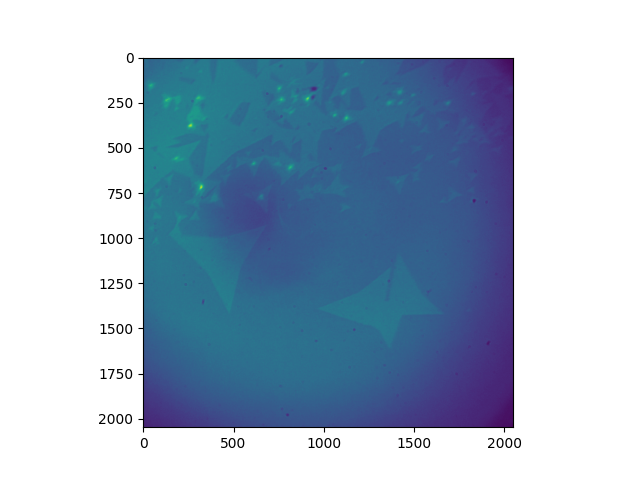

In [5]:
# Show first image
im0 = imageio.v3.imread(im_filenames[0])
plt.figure()
plt.imshow(im0, origin='upper')
plt.show()

In [6]:
# load all images into spec_map if stack is not created
# otherwise load image stack from HDF5 file as spec_map
Ny,Nx=im0.shape
Nz = len(im_filenames)

if os.path.exists(datadir + "/stack.h5"):
    with h5py.File(datadir + "/stack.h5", 'r') as h5f:
        spec_map = h5f['spec_map'][:]
else:
    spec_map = np.zeros((Ny,Nx,Nz), dtype=np.uint16)
    for i, fname in enumerate(im_filenames):
        spec_map[:,:,i] = imageio.v3.imread(fname)
    # Save data into an H5 file
    with h5py.File(datadir + "/stack.h5", 'w') as h5f:
      h5f['spec_map'] = spec_map

## Plot Intensity Maps and Spectra

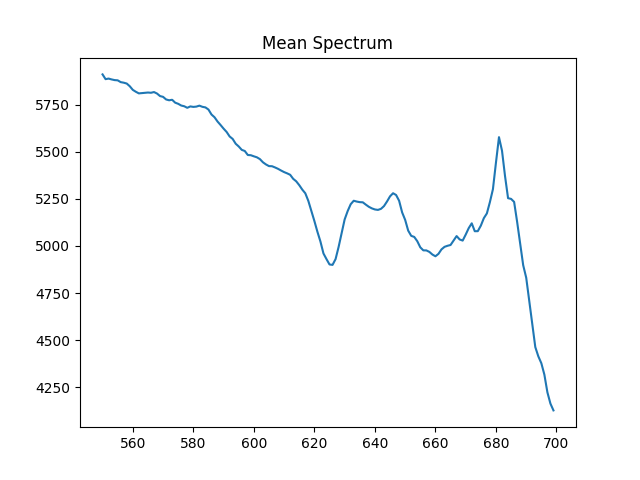

In [7]:
wls = np.arange(550,700,1.0)
plt.figure()
plt.plot(wls, spec_map.mean(axis=(0,1)))
plt.title("Mean Spectrum")
plt.show()

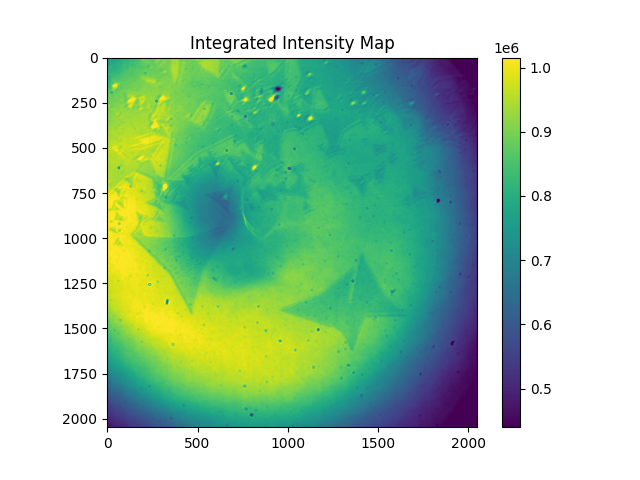

In [8]:
img = spec_map.sum(axis=-1)
plt.figure()
vmin,vmax = np.percentile(img, [1,99])
plt.imshow(img,vmin=vmin,vmax=vmax)
plt.title("Integrated Intensity Map")
plt.colorbar()

### Band Pass Image

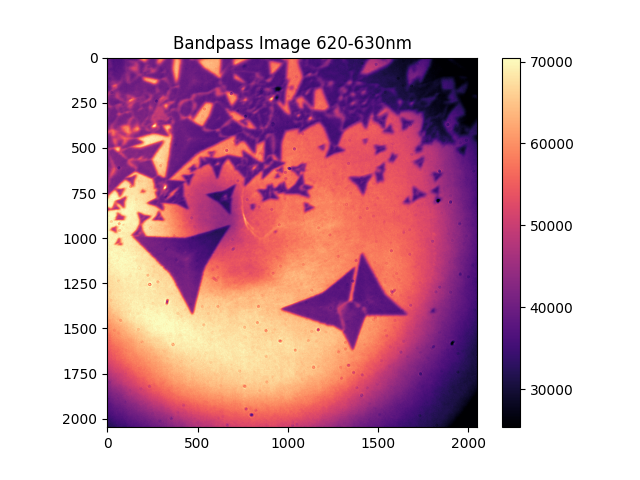

In [9]:
wl0 = 620 # Starting wavelength in nm
wl1 = 630 # Ending wavelength in nm

kk0,kk1 = np.searchsorted(wls, (wl0,wl1))
bandpass_image = spec_map[:,:,kk0:kk1].sum(axis=-1)
plt.figure()

vmin,vmax = np.percentile(bandpass_image, [1,99])
plt.imshow(bandpass_image,vmin=vmin,vmax=vmax, cmap=plt.cm.magma)
plt.title(f"Bandpass Image {wl0}-{wl1}nm")
plt.colorbar()

## Code to select regions of interest

In [10]:
import matplotlib.pyplot as plt
import IPython.display as Disp
from ipywidgets import widgets
import numpy as np

class polygon_hyperspec_select():
    %matplotlib widget
    # for colab

    def __init__(self,im, select_name='area1'):
        self.im = im
        self.select_name = select_name
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        ax.set_title(f"selecting: {select_name}")

        try:
          with h5py.File(datadir + "/stack.h5", 'r') as h5f:
              if select_name in h5f:
                self.selected_points = list(h5f[select_name]['points'][:])
                self.mask = h5f[select_name]['mask'][:]
              else:
                self.selected_points = []
                self.mask = np.zeros(self.im.shape, dtype=bool)
        except Exception as e:
          print(e)
          self.selected_points = []
          self.mask = np.zeros(self.im.shape, dtype=bool)

        self.plotpoints, = ax.plot([],[],'ro-')
        self.set_plotpoints_and_mask()



        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        save_button = widgets.Button(description="Save")
        reset_button = widgets.Button(description="Reset")

        Disp.display(disconnect_button)
        Disp.display(save_button)
        Disp.display(reset_button)

        reset_button.on_click(self.reset)
        save_button.on_click(self.save_mask)
        disconnect_button.on_click(self.disconnect_mpl)
        #self.fig.show()

    def set_plotpoints_and_mask(self):
        N = len(self.selected_points)
        if N>1:
          pt_arr = np.zeros((N+1, 2), dtype=float)
          pt_arr[:N,:] = np.array(self.selected_points)
          pt_arr[-1,:] = pt_arr[0,:]
          self.mask = skimage.draw.polygon2mask(self.im.shape,pt_arr[:-1,::-1])
          self.plotpoints.set_data(pt_arr[:,0],pt_arr[:,1])

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        self.set_plotpoints_and_mask()
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)
    def save_mask(self,_):
        with h5py.File(datadir + "/stack.h5", 'a') as h5f:
            if not self.select_name in h5f:
                h5f.create_group(self.select_name)
            if 'points' in h5f[self.select_name]:
                del h5f[self.select_name]['points']
            if 'mask' in h5f[self.select_name]:
                del h5f[self.select_name]['mask']
            h5f[self.select_name]['points'] = self.selected_points
            h5f[self.select_name]['mask'] = self.mask
    def reset(self,_):
        self.selected_points = []
        self.mask = np.zeros(self.im.shape, dtype=bool)
        self.plotpoints.set_data([0],[0])

## Find Reference (substrate) Area

Button(description='Disconnect mpl', style=ButtonStyle())

Button(description='Save', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

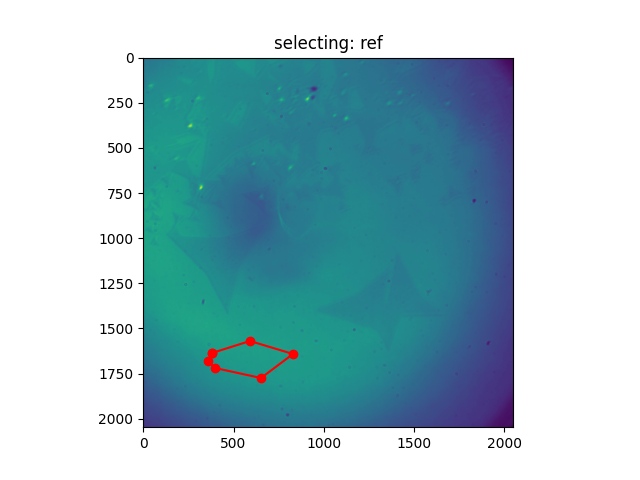

In [11]:
ref_select = polygon_hyperspec_select(spec_map.mean(axis=2), select_name='ref')

In [12]:
ref_select.selected_points
np.array(ref_select.selected_points)

array([[ 380.72943723, 1636.34848485],
       [ 591.29220779, 1569.85497835],
       [ 829.56060606, 1641.88961039],
       [ 652.24458874, 1774.87662338],
       [ 397.35281385, 1719.46536797],
       [ 358.56493506, 1680.67748918]])

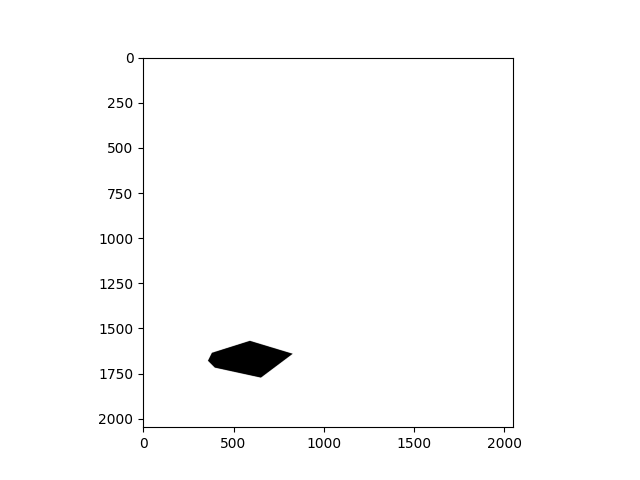

Text(0.5, 1.0, 'reference mask')

In [13]:
plt.figure()
plt.imshow(ref_select.mask, cmap='Greys')
plt.show()
plt.title("reference mask")


Text(0.5, 1.0, 'Raw Reference Spectrum')

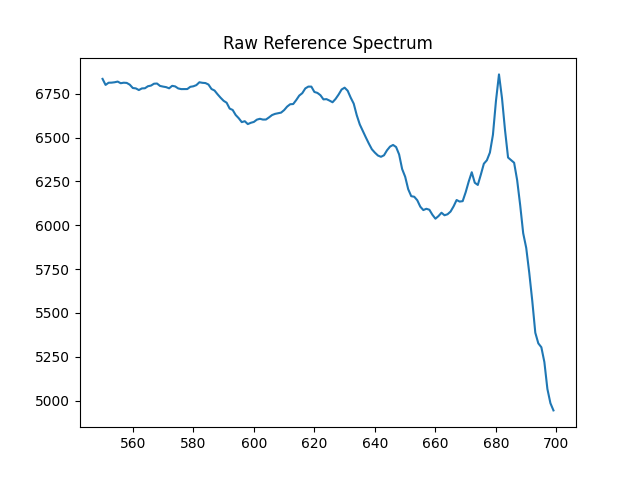

In [14]:
ref_specs = spec_map[ref_select.mask]
ref_spec = ref_specs.mean(axis=0)
plt.figure()
plt.plot(wls, ref_spec)
plt.title("Raw Reference Spectrum")

:# Compute Differential Reflectance

$\frac{R - R_{ref}}{R}$

Where $R_{ref}$ is the reflectance spectrum from the substrate area.

In [15]:
diff_ref_map = (spec_map - ref_spec)/spec_map

Text(0.5, 1.0, 'Mean Differential Reflectance Spectrum')

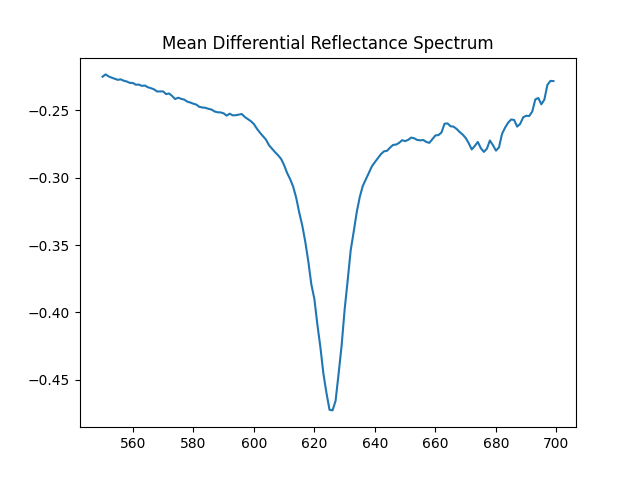

In [16]:
plt.figure()
plt.plot(wls, diff_ref_map.mean(axis=(0,1)))
plt.title("Mean Differential Reflectance Spectrum")

## Select and Plot Flake Diff Refl Spectra

Button(description='Disconnect mpl', style=ButtonStyle())

Button(description='Save', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

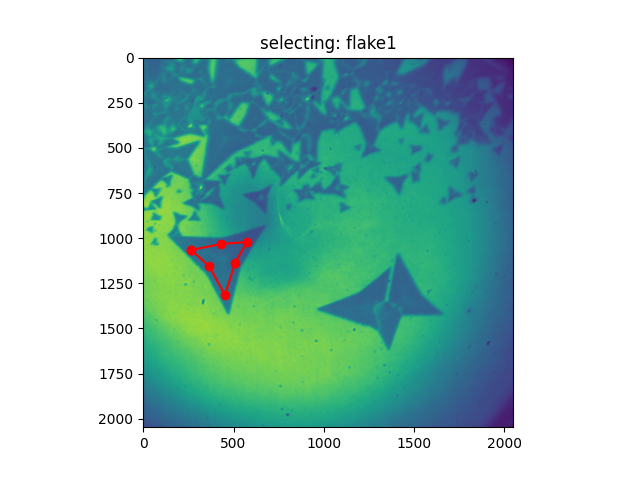

In [25]:
flake1_select = polygon_hyperspec_select(bandpass_image, select_name='flake1')

Button(description='Disconnect mpl', style=ButtonStyle())

Button(description='Save', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

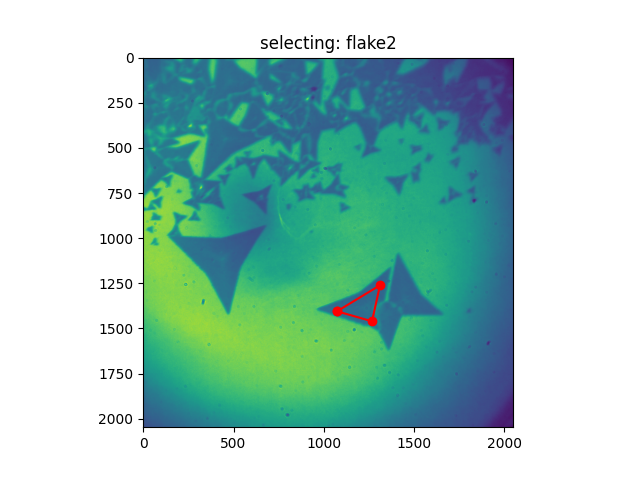

In [26]:
flake2_select = polygon_hyperspec_select(bandpass_image, select_name='flake2')

Button(description='Disconnect mpl', style=ButtonStyle())

Button(description='Save', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

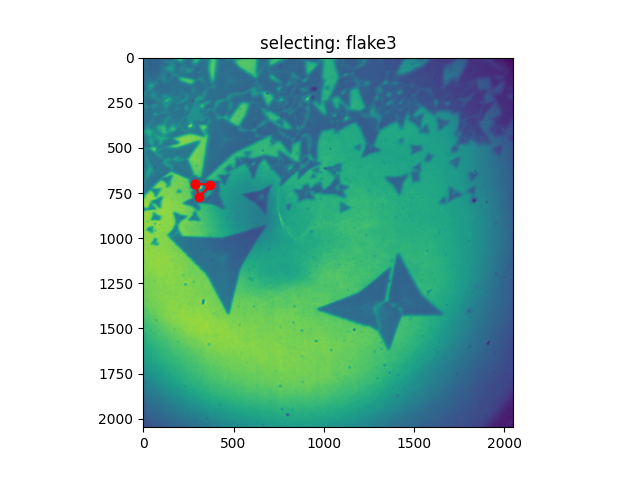

In [27]:
flake3_select = polygon_hyperspec_select(bandpass_image, select_name='flake3')

Text(0.5, 1.0, 'Differential Reflectance Spectra')

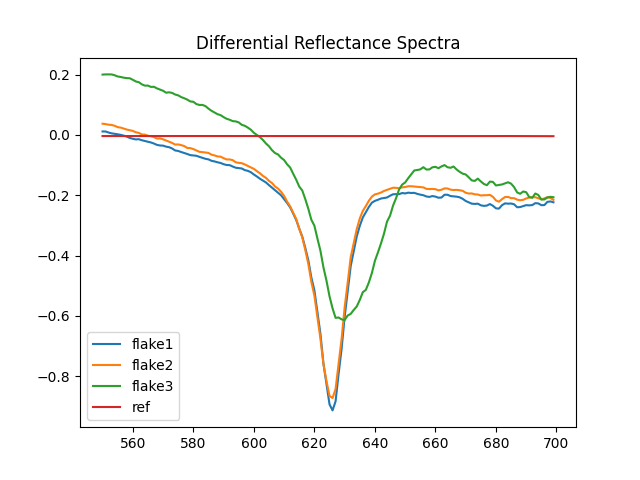

In [28]:
plt.figure()

area1_specs = diff_ref_map[flake1_select.mask]
area1_spec = area1_specs.mean(axis=0)
plt.plot(wls, area1_spec, label='flake1')

area2_specs = diff_ref_map[flake2_select.mask]
area2_spec = area2_specs.mean(axis=0)
plt.plot(wls, area2_spec, label='flake2')

area3_specs = diff_ref_map[flake3_select.mask]
area3_spec = area3_specs.mean(axis=0)
plt.plot(wls, area3_spec, label='flake3')

norm_ref_specs = diff_ref_map[ref_select.mask]
norm_ref_spec = norm_ref_specs.mean(axis=0)

plt.plot(wls, norm_ref_spec, label='ref')
plt.legend()
plt.title("Differential Reflectance Spectra")